# Load and clean Australia data related job dataset

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import itertools
from matplotlib import pyplot as plt

In [29]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords 
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/nanxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nanxu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/nanxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
data_jobs_AU  = pd.read_csv('job_ad_unique_au_14122021.csv')

In [6]:
data_jobs_AU.head()

,Unnamed: 0,job_title,job_link,company_name,salary,job_location,job_requirements,job_classifiation,short_description,salary_ind,date_posted,work_type,long_description
0,0,Order Processing & Customer Service,/job/55244809?type=promoted#searchRequestToken...,KG Foods,NaN,Sydney,"['Attractive Remuneration Package', 'Based on ...",Administration & Office Support,"Do you have an analytical mind, good attention...",0-60000,NaN,Full time,Order Processing/Customer Service Kids Gourm...
1,1,Technical Business Analyst - Graduate,/job/55325517?type=promoted#searchRequestToken...,DGIT Systems,NaN,Melbourne,"['Technical Analyst role with exciting work', ...",Information & Communication Technology,We’re looking for someone with practical devel...,0-60000,NaN,Full time,About DGITDGIT is a specialist telecommunicati...
2,2,Data Analyst / Consultant,/job/55305680?type=standard#searchRequestToken...,Cowra High School,NaN,Blue Mountains & Central West,NaN,Education & Training,Data Analyst / Consultant for High Schools,0-60000,NaN,Part time,EOI Expressions of Interest School Data Analys...
3,3,Data Entry Administrator,/job/55321894?type=standout#searchRequestToken...,Link Resources Pty Ltd,NaN,Sunshine Coast,['Dynamic growing business providing opportuni...,Administration & Office Support,Data Entry Administrator Based on the Sunshine...,0-60000,NaN,Full time,Link Resources Training is a Registered Traini...
4,4,"Data Entry, Casual",/job/55320305?type=standard#searchRequestToken...,Insane Technologies,$27 - $30 per hour,Gold Coast,NaN,Administration & Office Support,"Flexible work 20-40 hours per week, $27-$30 pe...",0-60000,NaN,$27 - $30 per hourCasual/Vacation,We are based on the Gold Coast and protect sma...


Remove 2 columns 'Unnamed: 0' and 'date_posted'

In [7]:
AU_jobs = data_jobs_AU.drop(['Unnamed: 0','job_link','date_posted'], axis=1)

In [8]:
AU_jobs.columns.values

array(['job_title', 'company_name', 'salary', 'job_location',
       'job_requirements', 'job_classifiation', 'short_description',
       'salary_ind', 'work_type', 'long_description'], dtype=object)

In [9]:
AU_jobs.isnull().sum()

job_title               0
company_name           33
salary               1346
job_location            0
job_requirements      959
job_classifiation       0
short_description       0
salary_ind              0
work_type               1
long_description        1
dtype: int64

In [10]:
job_title = AU_jobs['job_title'].value_counts()
job_title

Business Analyst                                                104
Data Analyst                                                     72
Data Engineer                                                    45
Senior Data Engineer                                             25
Technical Business Analyst                                       25
                                                               ... 
Data Analyst - 3 Month Contract                                   1
Senior Process Business Analyst                                   1
Senior Business Analyst - Remediation & Automation (Banking)      1
Data/System Analyst Modellers                                     1
Data & Business Analyst                                           1
Name: job_title, Length: 1410, dtype: int64

Group job title

In [175]:
#initializing count vectorizer to examine text-based data for logistic regression. 
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',ngram_range=(1, 3), min_df = .05)
#(stopwords.words('english'))

In [176]:
def jobtitlefunc(x):
    if x['business analyst'] == 1.0 and x['senior'] == 1.0:
        x['senior business analyst'] = 1
    else:
        x['senior business analyst'] = 0
    
    if x['data analyst'] == 1.0 and x['senior'] == 1.0:
        x['senior data analyst'] = 1
    else:
        x['senior data analyst'] = 0
        
    if x['business analyst'] == 1.0 and x['senior'] == 0.0:
        x['business analyst tidy'] = 1
    else:
        x['business analyst tidy'] = 0   
        
    if x['data analyst'] == 1.0 and x['senior'] == 0.0:
        x['data analyst tidy'] = 1
    else:
        x['data analyst tidy'] = 0
    
    if x['data engineer'] == 1.0 and x['senior'] == 1.0:
        x['senior data engineer'] = 1
    else:
        x['senior data engineer'] = 0
        
    if x['data engineer'] == 1.0 and x['senior'] == 0.0:
        x['data engineer tidy'] = 1
    else:
        x['data engineer tidy'] = 0 
        
    return x

In [177]:
#fitting count vectorizer to job title
cvec.fit(AU_jobs["job_title"])
#transforming job_title data into job_train
job_title = pd.DataFrame(cvec.transform(AU_jobs["job_title"]).todense(),
                       columns=cvec.get_feature_names())
job_title['senior business analyst'] = 0
job_title['senior data analyst'] = 0
job_title['senior data engineer'] = 0
job_title['business analyst tidy'] = 0
job_title['data analyst tidy'] = 0
job_title['data engineer tidy'] = 0

job_title_senior = job_title.apply(jobtitlefunc, axis=1)

CountVectorizer(min_df=0.05, ngram_range=(1, 3), stop_words='english')

In [178]:
job_title_senior.drop(['analyst','analytics','business','data','engineer','entry', 'senior','data analyst','business analyst','data engineer'], axis=1, inplace =True)
job_title_senior.rename({'data analyst tidy':'data analyst','business analyst tidy':'business analyst','data engineer tidy':'data engineer'}, axis=1, inplace = True)

In [182]:
job_title_senior

(2057, 8)

In [11]:
AU_jobs['salary_ind'].value_counts()

0-60000          514
60000-80000      364
200000-999999    311
150000-200000    275
120000-150000    210
80000-100000     207
100000-120000    177
Name: salary_ind, dtype: int64

In [12]:
AU_jobs['work_type'].value_counts()

Full time                                                     890
Contract/Temp                                                 388
Casual/Vacation                                                37
Part time                                                      30
Base + Super + Profit ShareFull time                            9
                                                             ... 
Base + Super + Performance Bonus + Share Options!Full time      1
$120k to $170k base + superFull time                            1
$850 - $900 p.d.Contract/Temp                                   1
Competitive RemunerationFull time                               1
Base Salary - Full Time - 6 Month ContractContract/Temp         1
Name: work_type, Length: 610, dtype: int64

In [13]:
df = pd.DataFrame((AU_jobs['salary_ind']).str.replace('-',' ').str.split())
AU_jobs['Min_income'] = df.salary_ind.apply(lambda x: int(x[0]))
AU_jobs['Max_income'] = df.salary_ind.apply(lambda x: int(x[1]))
AU_jobs['avg_income'] = df.salary_ind.apply(lambda x: int(x[0]) if int(x[1])==999999 else int(x[1]) \
                                                      if int(x[0])==0 else (int(x[0])+int(x[1]))/2)

In [14]:
AU_jobs['avg_income'].value_counts()

60000.0     514
70000.0     364
200000.0    311
175000.0    275
135000.0    210
90000.0     207
110000.0    177
Name: avg_income, dtype: int64

In [58]:
AU_jobs.drop(['salary','Min_income','Max_income'], axis =1)
AU_jobs.head()

,job_title,company_name,job_location,job_requirements,job_classifiation,short_description,salary_ind,work_type,long_description,avg_income,state
0,Order Processing & Customer Service,KG Foods,Sydney,"['Attractive Remuneration Package', 'Based on ...",Administration & Office Support,"Do you have an analytical mind, good attention...",0-60000,Full time,Order Processing/Customer Service Kids Gourm...,60000.0,New South Wales
1,Technical Business Analyst - Graduate,DGIT Systems,Melbourne,"['Technical Analyst role with exciting work', ...",Information & Communication Technology,We’re looking for someone with practical devel...,0-60000,Full time,About DGITDGIT is a specialist telecommunicati...,60000.0,Victoria
2,Data Analyst / Consultant,Cowra High School,Blue Mountains & Central West,NaN,Education & Training,Data Analyst / Consultant for High Schools,0-60000,Part time,EOI Expressions of Interest School Data Analys...,60000.0,New South Wales
3,Data Entry Administrator,Link Resources Pty Ltd,Sunshine Coast,['Dynamic growing business providing opportuni...,Administration & Office Support,Data Entry Administrator Based on the Sunshine...,0-60000,Full time,Link Resources Training is a Registered Traini...,60000.0,Queensland
4,"Data Entry, Casual",Insane Technologies,Gold Coast,NaN,Administration & Office Support,"Flexible work 20-40 hours per week, $27-$30 pe...",0-60000,$27 - $30 per hourCasual/Vacation,We are based on the Gold Coast and protect sma...,60000.0,Queensland
...,...,...,...,...,...,...,...,...,...,...,...
2053,Senior Business Analyst | 12 Month Contract | ...,Ashdown People,Sydney,NaN,Information & Communication Technology,"Identify, analyse and document business proces...",200000-999999,$800-$900/day + superContract/Temp,Job Summary Senior Business Analyst Salary: ...,200000.0,New South Wales
2054,Technical Business Analyst - Multiple positions,Morgan McKinley,Sydney,"['Leading Financial Services organisation', '1...",Information & Communication Technology,This is suitable for a Technical Business Anal...,200000-999999,$750 - $850 p.d. + SuperContract/Temp,Responsibilities:End-to-end CyberArk or Sailpo...,200000.0,New South Wales
2055,Senior Business Analyst (IT),TEKsystems,Sydney,NaN,Information & Communication Technology,Seeking a senior business analyst for high pro...,200000-999999,Contract/Temp,The role leads the review and analysis of the...,200000.0,New South Wales
2056,Solution Design Manager,SYPAQ Systems,Adelaide,NaN,Information & Communication Technology,"Multiple roles / Work in Canberra, Sydney, Bri...",200000-999999,Contract/Temp,\nDue to an increased demand within our busine...,200000.0,South Australia


,job_title,company_name,salary,job_location,job_requirements,job_classifiation,short_description,salary_ind,work_type,long_description,Min_income,Max_income,avg_income,state
0,Order Processing & Customer Service,KG Foods,NaN,Sydney,"['Attractive Remuneration Package', 'Based on ...",Administration & Office Support,"Do you have an analytical mind, good attention...",0-60000,Full time,Order Processing/Customer Service Kids Gourm...,0,60000,60000.0,New South Wales
1,Technical Business Analyst - Graduate,DGIT Systems,NaN,Melbourne,"['Technical Analyst role with exciting work', ...",Information & Communication Technology,We’re looking for someone with practical devel...,0-60000,Full time,About DGITDGIT is a specialist telecommunicati...,0,60000,60000.0,Victoria
2,Data Analyst / Consultant,Cowra High School,NaN,Blue Mountains & Central West,NaN,Education & Training,Data Analyst / Consultant for High Schools,0-60000,Part time,EOI Expressions of Interest School Data Analys...,0,60000,60000.0,New South Wales
3,Data Entry Administrator,Link Resources Pty Ltd,NaN,Sunshine Coast,['Dynamic growing business providing opportuni...,Administration & Office Support,Data Entry Administrator Based on the Sunshine...,0-60000,Full time,Link Resources Training is a Registered Traini...,0,60000,60000.0,Queensland
4,"Data Entry, Casual",Insane Technologies,$27 - $30 per hour,Gold Coast,NaN,Administration & Office Support,"Flexible work 20-40 hours per week, $27-$30 pe...",0-60000,$27 - $30 per hourCasual/Vacation,We are based on the Gold Coast and protect sma...,0,60000,60000.0,Queensland


In [84]:
#what is the median salary? (calculate mean salary, too, for fun)
print("salary median: " + str(AU_jobs["avg_income"].median()))
print("salary mean: " + str(AU_jobs["avg_income"].mean()))

salary median: 90000.0
salary mean: 113288.77005347594


In [86]:
#creating new target variable "above_med_sal" where 0 == below or equal to the median, and 1 == above the median; any postings without salary information will have NaN values for this variable
AU_jobs["above_med_sal"] = np.nan
AU_jobs['above_med_sal'] = AU_jobs.avg_income.apply(lambda x: 1 if x > AU_jobs['avg_income'].median() else 0)

,job_title,company_name,salary,job_location,job_requirements,job_classifiation,short_description,salary_ind,work_type,long_description,Min_income,Max_income,avg_income,state,above_med_sal
2053,Senior Business Analyst | 12 Month Contract | ...,Ashdown People,$800-$900/day + super,Sydney,NaN,Information & Communication Technology,"Identify, analyse and document business proces...",200000-999999,$800-$900/day + superContract/Temp,Job Summary Senior Business Analyst Salary: ...,200000,999999,200000.0,New South Wales,1
2054,Technical Business Analyst - Multiple positions,Morgan McKinley,$750 - $850 p.d. + Super,Sydney,"['Leading Financial Services organisation', '1...",Information & Communication Technology,This is suitable for a Technical Business Anal...,200000-999999,$750 - $850 p.d. + SuperContract/Temp,Responsibilities:End-to-end CyberArk or Sailpo...,200000,999999,200000.0,New South Wales,1
2055,Senior Business Analyst (IT),TEKsystems,NaN,Sydney,NaN,Information & Communication Technology,Seeking a senior business analyst for high pro...,200000-999999,Contract/Temp,The role leads the review and analysis of the...,200000,999999,200000.0,New South Wales,1
2056,Solution Design Manager,SYPAQ Systems,NaN,Adelaide,NaN,Information & Communication Technology,"Multiple roles / Work in Canberra, Sydney, Bri...",200000-999999,Contract/Temp,\nDue to an increased demand within our busine...,200000,999999,200000.0,South Australia,1
2057,Business Analyst - Multiple Opportunities,Arctic Fox,Good daily rates available,ACT,"['Multiple roles availabe', ""Seeking both 'Bus...",Consulting & Strategy,Seeking exceptional Business Analysts to work ...,200000-999999,Good daily rates availableContract/Temp,"Business BAs:Plan, facilitate and document use...",200000,999999,200000.0,New South Wales,1


Title vs salary analysis

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',ngram_range=(1, 3), min_df = .05)

#fitting count vectorizer to job title
cvec.fit(AU_jobs["job_title"])
#transforming job_title data into job_train
job_title = pd.DataFrame(cvec.transform(AU_jobs["job_title"]).todense(),
                       columns=cvec.get_feature_names())

In [227]:
above_med_sal = pd.DataFrame(AU_jobs['above_med_sal'])
word_observe = pd.concat([job_title, above_med_sal], axis=1)
word_observe.sample(10)

,data entry,manager,senior business analyst,senior data analyst,senior data engineer,business analyst,data analyst,data engineer,above_med_sal
194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1577,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
680,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
839,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [181]:
#Observing most common job title n-grams for both above and below median salaries
for i in range(2):
    word_count = word_observe[word_observe["above_med_sal"]==i].sum(axis=0)
    print (i, "most common words")
    cw = word_count.sort_values(ascending = False).head(20)
    print (cw)

0 most common words
data analyst               143.0
data entry                 131.0
business analyst            98.0
manager                     31.0
data engineer               30.0
senior data analyst         11.0
senior business analyst      5.0
senior data engineer         3.0
above_med_sal                0.0
dtype: float64
1 most common words
above_med_sal              973.0
business analyst           155.0
manager                     92.0
data engineer               53.0
senior business analyst     47.0
data analyst                46.0
senior data engineer        36.0
senior data analyst         14.0
data entry                   0.0
dtype: float64


In [191]:
#creating separate lists of the top appearing words so that these can be combined and compared to create ratios of appearances in above-median vs. below-median salaries
word_count_below = word_observe[word_observe["above_med_sal"]==0].sum(axis=0)
word_count_above = word_observe[word_observe["above_med_sal"]==1].sum(axis=0)
#creating as dataframe, using method ".T" to transpose columns with index.
word_count_compare = pd.DataFrame([word_count_below, word_count_above]).T
#creating a "ratio" column to determine frequency of words associated with above median jobs vs. below median jobs
word_count_compare["above_below_ratio"] = round(word_count_compare[1]/word_count_compare[0],2)
word_count_compare

,0,1,above_below_ratio
data entry,131.0,0.0,0.00
manager,31.0,92.0,2.97
senior business analyst,5.0,47.0,9.40
senior data analyst,11.0,14.0,1.27
senior data engineer,3.0,36.0,12.00
business analyst,98.0,155.0,1.58
data analyst,143.0,46.0,0.32
data engineer,30.0,53.0,1.77
above_med_sal,0.0,973.0,inf


In [16]:
group_location = pd.DataFrame((AU_jobs.groupby(['job_location']))['avg_income'].mean())
group_location.sort_values(by =['avg_income'], ascending =False)

,avg_income
job_location,
"Kalgoorlie, Goldfields & Esperance",200000.000000
ACT,137038.216561
Sydney,119832.439678
Toowoomba & Darling Downs,117500.000000
Brisbane,116265.306122
Melbourne,109956.521739
Darwin,100454.545455
Perth,98149.606299
Northern QLD,95000.000000


In [17]:
AU_jobs['state'] = AU_jobs.job_location.apply(lambda x: 'Western Australia' if x == 'Kalgoorlie, Goldfields & Esperance' or x == 'Geraldton, Gascoyne & Midwest'\
                                                        else 'New South Wales' if ('NSW') in x or x =='ACT' or x =='Sydney' or x == 'Newcastle, Maitland & Hunter'\
                                                              or x == 'Port Macquarie & Mid North Coast' or x == 'Blue Mountains & Central West'\
                                                              or x == 'Coffs Harbour & North Coast' or x == 'Wollongong, Illawarra & South Coast' \
                                                              or x == 'Gosford & Central Coast' or x == 'Hobart' or x =='Lismore & Far North Coast'\
                                                              or x == 'Southern Highlands & Tablelands' or x == 'Wagga Wagga & Riverina' \
                                                              or x == 'Albury Area'   \
                                                        else 'Queensland' if x == 'Toowoomba & Darling Downs' or x =='Brisbane'\
                                                              or x == 'Hervey Bay & Fraser Coast'\
                                                        else 'Victoria' if ('VIC') in x or x == 'Melbourne' or x =='Ballarat & Central Highlands'\
                                                              or x =='Shepparton & Goulburn Valley' or x == 'Mornington Peninsula & Bass Coast' \
                                                              or x =='Bairnsdale & Gippsland' or x == 'Bendigo, Goldfields & Macedon Ranges'\
                                                        else 'Western Australia' if x == 'Perth' or x =='Port Hedland, Karratha & Pilbara'\
                                                              or x == 'Northam & Wheatbelt' or x == 'Bunbury & South West'\
                                                        else 'Queensland' if ('QLD') in x or x == 'Sunshine Coast' or x =='Mackay & Coalfields'\
                                                              or x =='Cairns & Far North' or x == 'Bundaberg & Wide Bay Burnett' or x == 'Gold Coast'\
                                                        else 'South Australia' if x == 'Adelaide'
                                                        else x)

In [295]:
avg_income_by_state = AU_jobs.groupby(['state'])['avg_income'].describe()[['count', 'mean']].sort_values(by='mean',ascending = False)
avg_income_by_state.reset_index(inplace = True)
avg_income_by_state.head()

,state,count,mean
0,New South Wales,961.0,120359.001041
1,Queensland,286.0,111363.636364
2,Victoria,597.0,108927.973199
3,Darwin,11.0,100454.545455
4,Western Australia,134.0,97276.119403


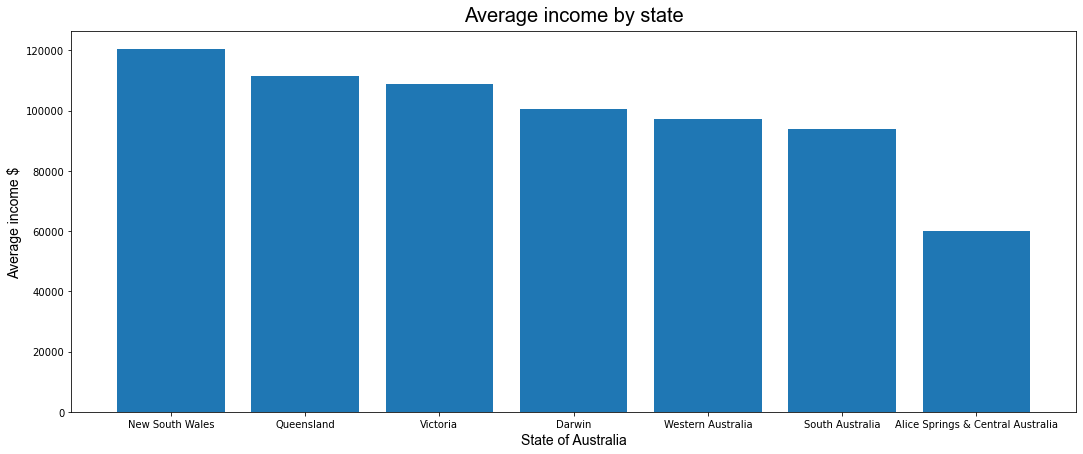

In [19]:
# Figure Size
fig = plt.figure(figsize =(18, 7))
 
# Horizontal Bar Plot
plt.bar(avg_income_by_state['state'],avg_income_by_state['mean'])

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} 
axis_font = {'fontname':'Arial', 'size':'14'}

plt.title('Average income by state', **title_font)
plt.xlabel('State of Australia', **axis_font)
plt.ylabel('Average income $', **axis_font)

# Show Plot
plt.show()

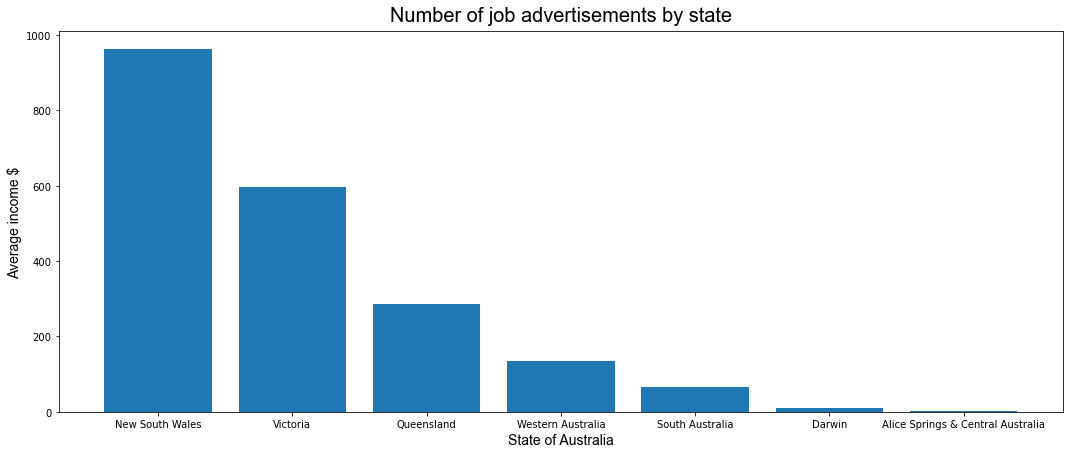

In [20]:
nu_jobs_by_state = avg_income_by_state.sort_values(by='count',ascending = False)
# Figure Size
fig = plt.figure(figsize =(18, 7))
 
# Horizontal Bar Plot
plt.bar(nu_jobs_by_state['state'],nu_jobs_by_state['count'])

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} 
axis_font = {'fontname':'Arial', 'size':'14'}

plt.title('Number of job advertisements by state', **title_font)
plt.xlabel('State of Australia', **axis_font)
plt.ylabel('Average income $', **axis_font)

# Show Plot
plt.show()

Analyse job descriptions

Remove NaN in long_description column; One row with NaN long_description.

In [22]:
#This splits all the sentences up which makes it easier for us to work with

all_sentences = []

for word in df:
    all_sentences.append(word)

all_sentences
#df1 = df.to_string()

#df_split = df1.split()

#df_split

lines = list()
for line in all_sentences:    
    words = line.split()
    for w in words: 
       lines.append(w)
lines[0:100]

['Order',
 'Processing/Customer',
 'Service',
 'Kids',
 'Gourmet',
 'Food',
 'is',
 'a',
 'volume',
 'catering',
 'business',
 'and',
 'the',
 'National',
 'leading',
 'provider',
 'of',
 'prepared',
 'meals',
 'to',
 'the',
 'childcare',
 'industry',
 'in',
 'Sydney,',
 'Brisbane',
 '&',
 'Melbourne.',
 'Our',
 'growing',
 'business',
 'is',
 'based',
 'on',
 'Sydney’s',
 'Northern',
 'Beaches,',
 'and',
 'we',
 'are',
 'looking',
 'for',
 'an',
 'Order',
 'Processing/Customer',
 'Service',
 'person.',
 'Working',
 'in',
 'our',
 'Business',
 'Development',
 'Team,',
 'you',
 'will',
 'take',
 'care',
 'of',
 'processing',
 'orders',
 'and',
 'customer',
 'service',
 'related',
 'activities.',
 'We',
 'are',
 'looking',
 'for',
 'a',
 'positive',
 'and',
 'energetic',
 'team',
 'member',
 'with',
 'database',
 'experience',
 'and',
 'excellent',
 'attention',
 'to',
 'detail.',
 'This',
 'is',
 'a',
 'full-time',
 'position',
 'with',
 'office',
 'hours',
 '8am',
 '–',
 '4pm.',
 'Key'

In [23]:
#Removing Punctuation

lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]

lines2 = []

for word in lines:
    if word != '':
        lines2.append(word)
        
lines2[0:10]

['Order',
 'ProcessingCustomer',
 'Service',
 'Kids',
 'Gourmet',
 'Food',
 'is',
 'a',
 'volume',
 'catering']

Check what technical tool is mentioned in the long description

In [34]:
#Removing all Stop Words

stem2 = []
stopWords = set(stopwords.words('english'))
stopWords.update(['data','business','experience','work','team','role','Data','skills',
                 'working','We','The','including','across','You','within', 'ability',
                  'new','Business','Experience','please','This','apply','Australia','provide','services'])
for word in lines2:
    if word not in stopWords:
        stem2.append(word)

stem2[0:100]

['Order',
 'ProcessingCustomer',
 'Service',
 'Kids',
 'Gourmet',
 'Food',
 'volume',
 'catering',
 'National',
 'leading',
 'provider',
 'prepared',
 'meals',
 'childcare',
 'industry',
 'Sydney',
 'Brisbane',
 'Melbourne',
 'Our',
 'growing',
 'based',
 'Sydneys',
 'Northern',
 'Beaches',
 'looking',
 'Order',
 'ProcessingCustomer',
 'Service',
 'person',
 'Working',
 'Development',
 'Team',
 'take',
 'care',
 'processing',
 'orders',
 'customer',
 'service',
 'related',
 'activities',
 'looking',
 'positive',
 'energetic',
 'member',
 'database',
 'excellent',
 'attention',
 'detail',
 'fulltime',
 'position',
 'office',
 'hours',
 '8am',
 '4pm',
 'Key',
 'Responsibilities',
 'include',
 'Order',
 'processing',
 'printing',
 'internal',
 'website',
 'Maintain',
 'update',
 'customer',
 'database',
 'Customer',
 'service',
 'support',
 'Oversee',
 'monitor',
 'daily',
 'transport',
 'logistics',
 'Developing',
 'maintaining',
 'effective',
 'procedures',
 'andor',
 'processes',
 'ach

In [35]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
df = pd.DataFrame(stem2)
df = df[0].value_counts()
#df.to_csv('wordcount.csv')

In [36]:
#This will give frequencies of our words

from nltk.probability import FreqDist

freqdoctor = FreqDist()

for words in df:
    freqdoctor[words] += 1

freqdoctor

FreqDist({1: 22803, 2: 5003, 3: 2216, 4: 1390, 5: 998, 6: 698, 7: 552, 8: 437, 9: 367, 10: 345, ...})

In [37]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 1000x500 with 0 Axes>

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

Text(0.5, 1.0, 'Top Words Overall')

Text(0, 0.5, 'Word from Tweet')

Text(0.5, 0, 'Count of Words')

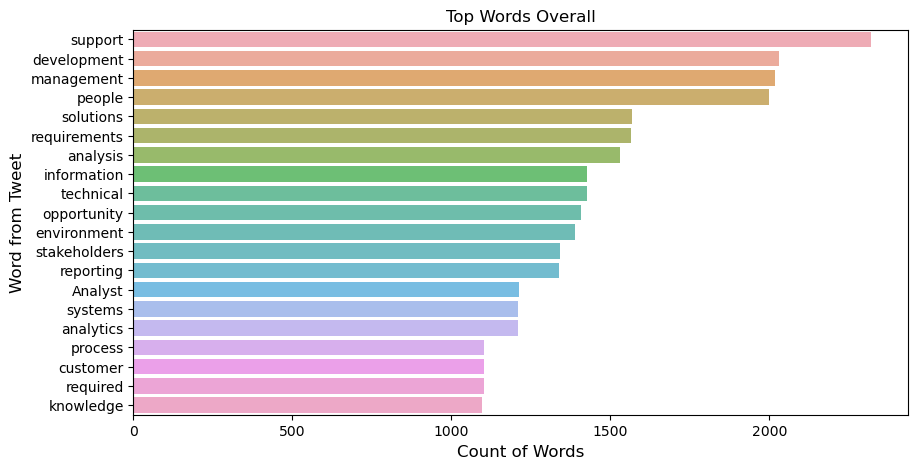

In [38]:
#This is a simple plot that shows the top 20 words being used
#df.plot(20)

df = df[:20,]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top Words Overall')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [39]:
AU_jobs['company_name'].value_counts()

Talent – SEEK Recruitment Agency of the Year | 7 Time Winner    30
SEEK Limited                                                    26
Bluefin Resources Pty Limited                                   25
Recruitment Hive                                                19
Paxus                                                           19
                                                                ..
TasNetworks                                                      1
Department of Treasury and Finance                               1
AusHealth                                                        1
Insane Technologies                                              1
Fortescue Future Industries                                      1
Name: company_name, Length: 1040, dtype: int64

In [206]:
def skillfunc(x):
    skills = ['python','r','django',"c++",'database','sql','sas','developer','cloud','visualisation','api','java']
    text = list(map(lambda y: y.lower(), x['long_description'].split()))
    for skill in skills:        
        if skill in text:
            x[skill+'_tag'] = 1
        else:
            x[skill+'_tag'] = 0
    return x

In [207]:
AU_jobs = AU_jobs[AU_jobs['long_description'].notnull()]
AU_jobs_complete = AU_jobs.apply(skillfunc,axis=1)
AU_jobs_complete.sample(10)

,job_title,company_name,salary,job_location,job_requirements,job_classifiation,short_description,salary_ind,work_type,long_description,...,django_tag,c++_tag,database_tag,sql_tag,sas_tag,developer_tag,cloud_tag,visualisation_tag,api_tag,java_tag
1969,Benefits Analyst - Federal Government,HiTech Personnel,NaN,Sydney,"['FEDERAL GOVERNMENT AGENCY', 'INITIAL 12 MONT...",Information & Communication Technology,FEDERAL GOVERNMENT AGENCY CONTRACT - BEENFITS ...,200000-999999,Contract/Temp,An established Federal Government Department i...,...,0,0,0,0,0,0,0,0,0,0
1604,Senior Data Engineer,IBM,NaN,Melbourne,"['Work on premium client accounts', 'Join this...",Information & Communication Technology,Leading client-facing team in the process of r...,150000-200000,Full time,IBM is the largest technology and consulting e...,...,0,0,0,1,0,0,1,0,0,0
1152,Data Governance Leader,Genworth,NaN,Sydney,['Take the next step on your data governance c...,Information & Communication Technology,"The next step in your data governance career, ...",100000-120000,Full time,Genworth is Australia’s leading provider of le...,...,0,0,0,0,0,0,0,0,0,0
642,Data and Reporting Project Officer,VCS Foundation Ltd,NaN,Melbourne,NaN,Consulting & Strategy,Rewarding and collaborative work environment ...,60000-80000,Contract/Temp,Rewarding and collaborative work environmentPu...,...,0,0,0,0,0,0,0,0,0,0
369,Graduate - Technology Associate - Canberra,Infosys limited,NaN,ACT,['Global leader in next-generation digital ser...,Information & Communication Technology,Join a leading Global organization and start d...,0-60000,Full time,About Infosys:Infosys is a global leader in ne...,...,0,0,1,1,0,0,1,0,0,1
299,Graduate - Technology Associate - Sydney,Infosys limited,NaN,Sydney,['Global leader in next-generation digital ser...,Information & Communication Technology,Join a Global market leading company and work ...,0-60000,Full time,About Infosys:Infosys is a global leader in ne...,...,0,0,1,1,0,0,1,0,0,1
965,Senior Data Analytics Consultant,RACQ,NaN,Brisbane,"['Excellent team culture', 'Career Opportuntit...",Banking & Financial Services,About the Company RACQ exists to make a positi...,80000-100000,Full time,About the Company\nRACQ exists to make a posit...,...,0,0,0,0,0,0,0,1,0,0
1885,Senior Business Analyst,Exclaim IT,Attractive hourly rate on offer!,Brisbane,['Extensive client engagement skills essential...,Information & Communication Technology,4 month contract opportunity for an excellent ...,200000-999999,Attractive hourly rate on offer!Contract/Temp,About the Role:\n\nOur client is seeking an ex...,...,0,0,0,0,0,0,0,0,0,0
879,SEO Specialist,Robert Walters,Attractive Salary Package,Sydney,"[""Work for Australia's leading and largest onl...",Marketing & Communications,"As the SEO Specialist, you'll be expected to o...",80000-100000,Attractive Salary PackageFull time,My Client is an Australian online bookstore. F...,...,0,0,0,0,0,0,0,0,0,0
797,Business Intelligence Analyst,IMC,NaN,Perth,"['Pronto package', 'BI Reporting', 'ERP Systems']",Information & Communication Technology,Seeking expressions of interest from Business ...,60000-80000,Full time,Iron Mine Contracting (IMC) was formed to prov...,...,0,0,0,0,0,0,0,0,0,0


In [57]:
Total = {
        'R': AU_jobs_complete['r_tag'].sum(), 
        'Django': AU_jobs_complete['django_tag'].sum(), 
        'C++': AU_jobs_complete['c++_tag'].sum(), 
        'Database': AU_jobs_complete['database_tag'].sum(), 
        'SQL': AU_jobs_complete['sql_tag'].sum(), 
        'SAS': AU_jobs_complete['sas_tag'].sum(), 
        'Developmer': AU_jobs_complete['developer_tag'].sum(), 
        'Cloud': AU_jobs_complete['cloud_tag'].sum(), 
        'Visualisation': AU_jobs_complete['visualisation_tag'].sum(), 
        'API': AU_jobs_complete['api_tag'].sum(),
        'Python': AU_jobs_complete['python_tag'].sum(),
        'Java': AU_jobs_complete['java_tag'].sum()
        }
Total

{'R': 74,
 'Django': 0,
 'C++': 7,
 'Database': 268,
 'SQL': 499,
 'SAS': 50,
 'Developmer': 85,
 'Cloud': 284,
 'Visualisation': 185,
 'API': 35,
 'Python': 173,
 'Java': 25}

In [218]:
skillset = AU_jobs_complete[['r_tag','django_tag','c++_tag','database_tag','sql_tag','sas_tag','developer_tag','cloud_tag','visualisation_tag','api_tag','python_tag','java_tag']]
skillset = pd.concat([job_title_senior,skillset,above_med_sal], axis =1)
skillset.head()

,data entry,manager,senior business analyst,senior data analyst,senior data engineer,business analyst,data analyst,data engineer,r_tag,django_tag,...,database_tag,sql_tag,sas_tag,developer_tag,cloud_tag,visualisation_tag,api_tag,python_tag,java_tag,above_med_sal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
for i in range(2):
    skill_count = skillset[skillset["above_med_sal"]==i].sum(axis=0)
    print (i, "most skill required")
    cw = skill_count.sort_values(ascending = False).head(20)
    print (cw)

0 most skill required
sql_tag                    230.0
data analyst               143.0
database_tag               141.0
data entry                 131.0
cloud_tag                  100.0
business analyst            98.0
visualisation_tag           82.0
python_tag                  76.0
r_tag                       34.0
manager                     31.0
data engineer               30.0
developer_tag               26.0
sas_tag                     20.0
java_tag                    11.0
senior data analyst         11.0
api_tag                      8.0
senior business analyst      5.0
senior data engineer         3.0
c++_tag                      1.0
django_tag                   0.0
dtype: float64
1 most skill required
above_med_sal              973.0
sql_tag                    269.0
cloud_tag                  184.0
business analyst           155.0
database_tag               127.0
visualisation_tag          103.0
python_tag                  97.0
manager                     92.0
developer_tag    

In [235]:
#word_observe[word_observe["above_med_sal"]==1.0].sum(axis=0)
#word_count_above = word_observe[word_observe["above_med_sal"]==1].sum(axis=0)
#skillset.columns.values.tolist()



['data entry',
 'manager',
 'senior business analyst',
 'senior data analyst',
 'senior data engineer',
 'business analyst',
 'data analyst',
 'data engineer',
 'r_tag',
 'django_tag',
 'c++_tag',
 'database_tag',
 'sql_tag',
 'sas_tag',
 'developer_tag',
 'cloud_tag',
 'visualisation_tag',
 'api_tag',
 'python_tag',
 'java_tag',
 'above_med_sal']

In [243]:
above_med_sal = skillset[skillset["above_med_sal"]==1]
above_med_sal[above_med_sal['data engineer']==1].sum(axis=0)


data entry                  0.0
manager                     0.0
senior business analyst     0.0
senior data analyst         0.0
senior data engineer        0.0
business analyst            0.0
data analyst                1.0
data engineer              53.0
r_tag                       8.0
django_tag                  0.0
c++_tag                     0.0
database_tag                8.0
sql_tag                    17.0
sas_tag                     1.0
developer_tag               4.0
cloud_tag                  10.0
visualisation_tag           8.0
api_tag                     0.0
python_tag                  8.0
java_tag                    1.0
above_med_sal              53.0
dtype: float64

In [244]:
AU_jobs.head()

,job_title,company_name,salary,job_location,job_requirements,job_classifiation,short_description,salary_ind,work_type,long_description,Min_income,Max_income,avg_income,state,above_med_sal
0,Order Processing & Customer Service,KG Foods,NaN,Sydney,"['Attractive Remuneration Package', 'Based on ...",Administration & Office Support,"Do you have an analytical mind, good attention...",0-60000,Full time,Order Processing/Customer Service Kids Gourm...,0,60000,60000.0,New South Wales,0
1,Technical Business Analyst - Graduate,DGIT Systems,NaN,Melbourne,"['Technical Analyst role with exciting work', ...",Information & Communication Technology,We’re looking for someone with practical devel...,0-60000,Full time,About DGITDGIT is a specialist telecommunicati...,0,60000,60000.0,Victoria,0
2,Data Analyst / Consultant,Cowra High School,NaN,Blue Mountains & Central West,NaN,Education & Training,Data Analyst / Consultant for High Schools,0-60000,Part time,EOI Expressions of Interest School Data Analys...,0,60000,60000.0,New South Wales,0
3,Data Entry Administrator,Link Resources Pty Ltd,NaN,Sunshine Coast,['Dynamic growing business providing opportuni...,Administration & Office Support,Data Entry Administrator Based on the Sunshine...,0-60000,Full time,Link Resources Training is a Registered Traini...,0,60000,60000.0,Queensland,0
4,"Data Entry, Casual",Insane Technologies,$27 - $30 per hour,Gold Coast,NaN,Administration & Office Support,"Flexible work 20-40 hours per week, $27-$30 pe...",0-60000,$27 - $30 per hourCasual/Vacation,We are based on the Gold Coast and protect sma...,0,60000,60000.0,Queensland,0


In [292]:
above_med_sal =AU_jobs.above_med_sal.unique()
#create a list of responses for each candidate using a list comprehension
corpus = [' '.join(AU_jobs[(AU_jobs.above_med_sal==candidate)].long_description.tolist()) for candidate in range(2)]

#lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in corpus]

# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#instantiate a CountVectorizer object
#utilize the new STOP_WORDS list
stopWords = set(stopwords.words('english'))
stopWords.update(['data','business','experience','work','team','role','Data','skills',
                 'working','We','The','including','across','You','within', 'ability',
                  'new','Business','Experience','please','This','apply','Australia','australia','provide','services',
                 'rea','com','au','pm','www','http'])
cv=CountVectorizer(stop_words=stopWords, ngram_range=(1, 3), min_df = .1)

# fit transform our text and create a dataframe with the result
X = cv.fit_transform(corpus)
X = X.toarray()

bow=pd.DataFrame(X, columns = cv.get_feature_names())
bow.index=above_med_sal

In [293]:
from tqdm import tqdm #used for progress bar
import math

#build an empty dataframe
t_bow_df=pd.DataFrame()

# By candidate, divide the number of times a word is said, 
# by the total number of times they've said all the words that they have said (frequency)
bow_transformed = bow.apply(lambda x: (x+1)/ (bow.loc[x.name].sum()+1), axis=1) 

for sal_indicator in tqdm(above_med_sal):
    feat_s = bow[bow.index != sal_indicator].sum()+1 #sum all the times each word was said excluding the candidate
    feat_s_all = np.sum(bow[bow.index != sal_indicator].sum()) # all the total words that were said, excluding the candidate
    tot = feat_s / feat_s_all #find the frequency of words said among other candidates
    row = bow_transformed.loc[sal_indicator] / tot #divide the candidate's array of frequency of words by all other candidates' frequency
    row = pd.DataFrame(row).T #create a df, and transform
    results = row.apply(lambda x: math.log(x,2)) #take the log of each frequency
    
    t_bow_df = pd.concat([t_bow_df, pd.DataFrame([results], index=[sal_indicator])]) #append to df


100%|██████████| 2/2 [00:52<00:00, 26.46s/it]


(-0.5, 399.5, 199.5, -0.5)

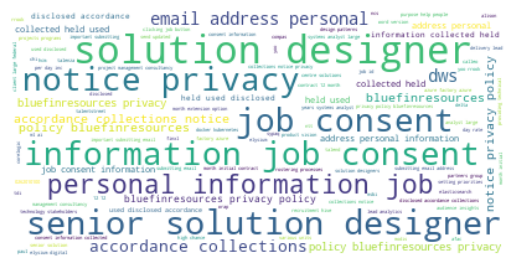

In [294]:
# create a pandas Series of the top 4000 most frequent words
text=t_bow_df.loc[1].sort_values(ascending=False)[:4000]

# create a dictionary Note: you could pass the pandas Series directoy into the wordcloud object
text2_dict=t_bow_df.loc[1].sort_values(ascending=False).to_dict()

# create the WordCloud object
wordcloud = WordCloud(min_word_length =3,
                      background_color='white')

# generate the word cloud
wordcloud.generate_from_frequencies(text2_dict)

#plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()